<a href="https://colab.research.google.com/github/JoaoGranja/CIFAR10_ImageClassification/blob/master/image_classification_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
is_colab = False


# **Colab Preparation** 
Before handling the project, we need to install keras and pip packages. I also share my google drive to simplify the connection with my google drive account.



In [2]:
if is_colab:
    #Package Installation and share Google Drive
    !pip install --upgrade pip
    #!pip install --upgrade keras
    !pip install keras-resnet
    !pip install tensorflow==2.3.0
    !pip install tensorflow-gpu==2.3.0
    !pip install keras==2.4

    from google.colab import drive
    drive.mount('/content/drive')

 # **Configuration and imports**

First thing I do is to import all modules we need for this project. I also use some configuration parameters to be used through the project

In this project I will be making use of the Keras library for creating our model and training it. I will also use Matplotlib and Seaborn for visualizing our dataset to gain a better understanding of the images we are going to be handling. Another important library to handle image data is Opencv.



In [3]:
# Generic Imports
import time
import gc
import logging, os
import sys
import random
import warnings
import pickle
from math import ceil
from tqdm import tqdm
from itertools import chain

# data processing and visualization library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# image procesing library
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
import cv2 

# tensorflow and keras for CNN model
import tensorflow as tf
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Model, save_model, load_model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras import backend as K
from tensorflow.keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.datasets import cifar10
#from keras.utils import multi_gpu_model
from tensorflow.keras.preprocessing.image import Iterator, load_img, img_to_array

if is_colab:
    from google.colab import files
    sys.path.append('/content/drive/MyDrive/colab/CIFAR100_Image_Classification')
    os.chdir('/content/drive/MyDrive/colab/CIFAR100_Image_Classification')
    
#------------------------------  Set some configuration parameters -----------------------------------#
args = {}
args['seed'] = 42
args['data_augmentation'] = False
args['training'] = False

#training arguments
args['batch_size'] = 32
args['epochs'] = 10
args['validation_split'] = 0.2

#model arguments
args['networks'] = ['LeNet', 'VGG16', 'VGG19']
#args['networks'] = ['LeNet']

#optimizer arguments
args['optimizer'] = 'adam'
args['learning_rate'] = 0.001
args['decay'] = 0.0001
args['loss'] = 'sparse_categorical_crossentropy'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

## Loading the dataset

In this project I will use the CIFAR100 dataset which is comprised of 60000 32x32 color images in 100 classes, with 600 images per class. There are 50000 training images and 10000 test images. More information is available on [CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html)|

In [4]:
def unpickle(file):
    with open(file, 'rb') as data:
        dataset = pickle.load(data)
    return dataset

In [5]:
#------------------------------  Load dataset using keras.dataset API -----------------------------------#
download_dataset = False
if download_dataset:
    train_ds, valid_ds = cifar100.load_data()
    dataset = {}
    dataset['train_ds'], dataset['valid_ds'] = train_ds, valid_ds
    with open('dataset/cifar100.pickle', 'wb') as output:
        pickle.dump(dataset, output)
else:
    dataset = unpickle('dataset/cifar100.pickle')
    train_ds, valid_ds = dataset['train_ds'], dataset['valid_ds']


#Check train and test dataset shape
x_train, y_train = train_ds
print("Train dataset: x={} y={}".format(x_train.shape, y_train.shape))
#Check number of classes and image shape
print("Image data shape =", x_train.shape[1:])
nr_classes = len(np.unique(y_train))
print("Number of classes =", nr_classes )

x_test, y_test = valid_ds
print("Test dataset: x={} y={}".format(x_test.shape, y_test.shape))
   

Train dataset: x=(50000, 32, 32, 3) y=(50000, 1)
Image data shape = (32, 32, 3)
Number of classes = 100
Test dataset: x=(10000, 32, 32, 3) y=(10000, 1)


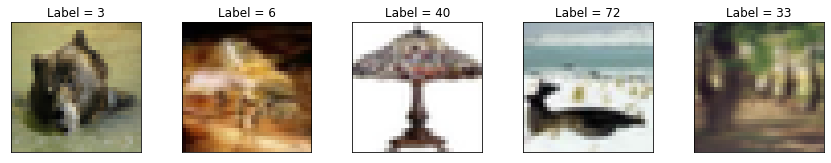

In [6]:
#------------------------------ Plot random images and respective labels -----------------------------------#
n_images = 5
fig, axs = plt.subplots(1, n_images, figsize=(12, 12))
fig.tight_layout(pad=1.0)
   
for i in range(n_images):
    index = random.randint(0, len(x_train))
    image = x_train[index].squeeze()

    axs[i].imshow(image)
    axs[i].set_title("Label = {0}".format(int(y_train[index])))
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)


Analyzing the images it is clear that the images resolution is small, actually 32x32 has few pixels and therefore can be a challenge for a model to classify correctly the object. Furthermore all image has the same size so it is not required to resize the input images.

# **Pre-processing the train and test dataset**

In [7]:
#------------------------------ Random data augmentation -----------------------------------#
if args['data_augmentation']:
    train_datagen = ImageDataGenerator(
                        rescale=1./255,
                        featurewise_center=True,
                        featurewise_std_normalization=True,
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        horizontal_flip=True,
                        validation_split=0.2)
    # prepare iterator
    train_generator = train_datagen.flow(x_train, y_train, batch_size=args['batch_size'])

    
    test_datagen = ImageDataGenerator(rescale=1./255)   
    validation_generator = test_datagen.flow(x_test, y_test, batch_size=args['batch_size'])

else:
    train_datagen = ImageDataGenerator(rescale=1./255)   
    train_generator = train_datagen.flow(x_train, y_train, batch_size=args['batch_size'])
    validation_generator = train_datagen.flow(x_test, y_test, batch_size=args['batch_size'])



# **Optimizer**

Before training it is necessary to choose an optimizer which will be responsible to adjust model parameters in order to reduce the loss funcion

In [8]:
#------------------------------ Define an optimizer -----------------------------------#
if 'optimizer' in args:
    if args['optimizer'] == 'rmsprop':
        optimizer = RMSprop(learning_rate=args['learning_rate'], decay=float(args['decay']))
    elif args['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=args['learning_rate'], decay=float(args['decay']))
    elif args['optimizer'] == 'amsgrad':
        optimizer = Adam(learning_rate=args['learning_rate'], decay=float(args['decay']), amsgrad=True)
    elif args['optimizer'] == 'sgd':
        optimizer = SGD(learning_rate=args['learning_rate'], momentum=0.9, nesterov=True, decay=float(args['decay']))
else:
    optimizer = RMSprop(learning_rate=args['learning_rate'])

# **Model**

In this project, I will first use a simple CNN model following the LeNet architecture.

In [9]:
from models.model_factory import make_model

models = []
for network in args['networks']:
    #------------------------------ Make the model -----------------------------------#
    model = make_model(network, x_train.shape[1:], nr_classes)

    if 'weights' not in args:
        print('No weights passed, training from scratch')
    else:
        weights_path = args['weights']
        print('Loading weights from {}'.format(weights_path))
        model.load_weights(weights_path, by_name=True)

    #------------------------------ Compile the model -----------------------------------#
    model.compile(loss=args['loss'], optimizer=optimizer, metrics=['accuracy']) 
    model.summary()
    models.append(model)

No weights passed, training from scratch
Model: "LeNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (Max

# **Training**

In [ ]:
args['models_dir'] = 'nn_models_checkpoints'

if args['training']:
    histories = {}
    for model in models:
    print("Training model {}".format(model.name))
    #------------------------------ Model check points -----------------------------------#
    best_model_file = '{}/best_{}.h5'.format(args['models_dir'], model.name)
    last_model_file = '{}/last_{}.h5'.format(args['models_dir'], model.name)
    model_file = '{}/model_{}.h5'.format(args['models_dir'], model.name)

    #------------------------------ Callbacks -----------------------------------#
    callbacks = [
            # Callback to reduce the learning rate once the plateau has been reached:
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=1/3,
                patience=2,
                mode='auto',
                verbose=1,
                cooldown=0,
                min_lr=1e-8
            ),
            # Callback to stop the training once no more improvements are recorded:
            EarlyStopping(
                min_delta=0.001,
                verbose=1,
                patience=5,
                mode='auto',
                restore_best_weights=True
            ),
            # Callback to log the graph, losses and metrics into TensorBoard:
            TensorBoard(log_dir="logs/{}".format(model.name)
            ),
            # Callback to save the best and last model specifying the epoch and val-loss in the filename:
            ModelCheckpoint(filepath=last_model_file, 
                monitor='val_loss',
                verbose=1,
                mode='min',
                save_freq='epoch',
                save_best_only=False,
                save_weights_only=False
            ),
            ModelCheckpoint(filepath=best_model_file, 
                monitor='val_loss',
                verbose=1,
                mode='min',
                save_freq='epoch',
                save_best_only=True,
                save_weights_only=False)
        ]

    #------------------------------ Model Fit -----------------------------------#
    steps = int(x_train.shape[0] /args['batch_size'])
    history = model.fit(
                        train_generator,
                        steps_per_epoch=steps,
                        epochs=args['epochs'],
                        validation_data=validation_generator,
                        callbacks=callbacks)
    histories[model.name] = history

    #------------------------------ Save the last model weights -----------------------------------#
    model.save(model_file)
    print("Saved model to disk") 

Training model LeNet
Epoch 1/10
 898/1562 [================>.............] - ETA: 1:00 - loss: 4.7374 - accuracy: 0.0079

# **Visualise Model Results**

In [ ]:
#------------------------------ Plot diagnostic learning curves -----------------------------------#
def summarize_diagnostics(history, model_name):
    # plot loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(15, 15))
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # save plot to file
    filename = "accuracy_" + model_name 
    plt.savefig(filename + '_plot.png')
    plt.show()
    plt.close()

    plt.figure(figsize=(15, 15))
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    # save plot to file
    filename = "loss_" + model_name 
    plt.savefig(filename + '_plot.png')
    plt.show()
    plt.close()

if args['training']:  
    for model_name in histories:
        summarize_diagnostics(histories[model_name], model_name)



# **Evaluation**

Evaluate the model over the test dataset. We will use the last model weights and predict the class for some test images

In [ ]:
try:
    del models
except:
    print('No models exists')
gc.collect

def show_image_prediction(loaded_model, n_images):
    #Try out the model on an image from the test data:
    fig, axs = plt.subplots(1, n_images, figsize=(12, 12))
    fig.tight_layout(pad=1.0)

    # View the images
    for i in range(n_images):
        index = random.randint(0, len(x_test))
        image = x_test[index].squeeze()
        true_index = int(y_test[index])

        prediction_scores = loaded_model.predict(np.expand_dims(image, axis=0))
        predicted_index = np.argmax(prediction_scores)

        image = np.add(image*128,128).astype(int)
        axs[i].imshow(image)
        axs[i].set_title("True Label = {0}, \n Predicted label = {1}".format(class_names[true_index], class_names[predicted_index]))
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)

#------------------------------ Predict on some test images -----------------------------------#
plt.figure(figsize=(30, 30))
i=1
for network in args['networks']:
    plt.subplot(1, len(args['networks']), i)
    #Load last model parameters
    last_model_file = '{}/last_{}.h5'.format(args['models_dir'], network)
    best_model_file = '{}/best_{}.h5'.format(args['models_dir'], network)
    model_file = '{}/model_{}.h5'.format(args['models_dir'], network)

    #model = make_model(network, x_train.shape[1:], nr_classes)
    #model.load_weights(best_model_file)

    #Load the model
    loaded_model = load_model(model_file)
    print("Loaded model {} from disk".format(model_file))
    loaded_model.compile(loss=args['loss'], optimizer=optimizer, metrics=['accuracy']) 

    #Try out the model on an image from the test data:
    #show_image_prediction(loaded_model, 5)

    #------------------------------ Evaluate model on testing dataset -----------------------------------#
    #_, acc = loaded_model.evaluate(x_train, y_train, verbose=0)
    #print("Training accuracy of model {0} = {1}".format(loaded_model.name, acc))
    #_, acc = loaded_model.evaluate(x_test, y_test, verbose=0)
    #print("Testing accuracy of model {0} = {1}".format(loaded_model.name, acc)) 

    #------------------------------ Plot all model results -----------------------------------#
    # save plot to file
    filename = "accuracy_" + network + '_plot.png'
    im = cv2.imread(filename)
    plt.imshow(im)
    plt.title("Accuray Results of model {}".format(network))
    i = i + 1

plt.show()
plt.close()

**Future Work**

In this project I applied transfer learning to several pre-trained models and train added fully connected layer parameters with the new dataset. However I could fine-tune 